# Necessary Libraries

In [1]:
import utils
import shutil
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List
from pathlib import Path

# Mutual Information

In [2]:
# Define the path of the main directory
MAIN_PATH = Path('../MIRA_Lab_02/').resolve()

# Define the path of training dataset directory
train_images_dir_path = MAIN_PATH / 'Dataset/Training/training-images'
train_labels_dir_path = MAIN_PATH / 'Dataset/Training/training-labels'
train_masks_dir_path  = MAIN_PATH / 'Dataset/Training/training-masks'
output_dir_path       = MAIN_PATH / 'Dataset/Training/training-outputs'

# Define the path of the registration parameter directory
parameter_dir_path    = MAIN_PATH / 'Parameter'

# Define the name of the registration parameter
reg_parameter = 'Par0009.affine.txt'

In [92]:
# Iterate over fixed images in the training directory
for i, fixed_image_path in tqdm(enumerate(train_images_dir_path.iterdir()), total=len(list(train_images_dir_path.iterdir())), desc='Registration Progressing'):
    # Get the id of the fixed image
    fixed_image_id = fixed_image_path.stem
    
    # Define the path of the output directory to store registered images
    output_path = output_dir_path / 'Par0009.affine' / fixed_image_id 
    
    # Check if the output directory is already available, if yes, skip registration
    if output_path.exists():
        continue
    
    # Create the output directory if it doesn't exist
    output_path.mkdir(exist_ok=True, parents=True)
    
    # Iterate over moving images in the training directory
    for j, moving_image_path in enumerate(train_images_dir_path.iterdir()):
        # Get the id of the moving image
        moving_image_id = moving_image_path.stem
        
        # Define the path of the registered image
        reg_image_path = output_path / f'reg_{moving_image_id}.nii.gz'
        
        # Check if fixed image and moving image are the same; if true, copy the image without registration
        if fixed_image_id == moving_image_id:
            shutil.copy(moving_image_path, reg_image_path)
            continue
        
        # Read and modify parameters from the registration parameter file
        reg_parameter_file_path = parameter_dir_path / reg_parameter
        field_value_pairs = [('ResultImageFormat', 'nii.gz')]
        utils.modify_field_parameter_map(field_value_pairs, reg_parameter_file_path)
        
        # Apply registration using elastix wrapper
        utils.elastix_wrapper(fixed_image_path, moving_image_path, reg_image_path, reg_parameter_file_path)


Registration Progressing:  13%|███████▍                                                | 2/15 [07:43<50:13, 231.82s/it]


KeyboardInterrupt: 

In [ ]:
# Define the path to the output directory containing registered images
output_image_path = output_dir_path / 'Par0009.affine'

# Initialize lists to store mutual information values and corresponding image names
mutual_information_df = []
index_list = []

# Iterate over registered image directories in the output directory
for reg_image_dir_path in tqdm(output_image_path.iterdir(), total=len(list(output_image_path.iterdir())), desc='Calculating Mutual Information'):
    reg_image_name = reg_image_dir_path.name
    index_list.append(reg_image_name)
    mutual_information_row = {}
    
    # Read the registered image
    reg_image = sitk.GetArrayFromImage(sitk.ReadImage(str(reg_image_dir_path / f'r_{reg_image_name}.nii.gz')))
    
    # Iterate over moving images in the registered image directory
    for moving_image_path in reg_image_dir_path.iterdir():
        # Skip files with .txt extension (assuming these are not images)
        if moving_image_path.name.endswith('txt'):
            continue
        
        # Read the moving image and calculate mutual information
        moving_image = sitk.GetArrayFromImage(sitk.ReadImage(str(moving_image_path)))
        # Store mutual information value in the dictionary
        mutual_information_row[(moving_image_path.stem).lstrip('reg_')] = utils.mutual_information(reg_image, moving_image)
    
    # Append mutual information values for each image to the list
    mutual_information_df.append(mutual_information_row)

# Create a DataFrame using mutual information values and corresponding image names as index
mutual_information_df = pd.DataFrame(mutual_information_df, index=index_list)

In [9]:
output_image_path = output_dir_path / 'Par0009.affine'
    
mutual_information_df = []
indexs = []

for reg_image_dir_path in tqdm(output_image_path.iterdir(), total = len(list(output_image_path.iterdir()))):
    reg_image_name = reg_image_dir_path.name
    indexs.append(reg_image_name)
    mutual_information_row = {}
    
    reg_image = sitk.GetArrayFromImage(sitk.ReadImage(str(reg_image_dir_path / f'r_{reg_image_name}.nii.gz')))
    for moving_image_path in reg_image_dir_path.iterdir():
        if moving_image_path.name.endswith('txt'):
            continue
        moving_image = sitk.GetArrayFromImage(sitk.ReadImage(str(moving_image_path)))
        mutual_information_row[(moving_image_path.name.rstrip('.nii.gz')).lstrip('r_')] = utils.mutual_information(reg_image, moving_image)
    mutual_information_df.append(mutual_information_row)
    
mutual_information_df = pd.DataFrame(mutual_information_df, index=indexs)
mutual_information_df          

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [14:17<00:00, 57.14s/it]


,1000,1001,1002,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1017,1036
1000,1.700416,0.557975,0.529872,0.536356,0.539745,0.580518,0.592444,0.561715,0.583960,0.568665,0.573474,0.581978,0.522726,0.561976,0.512196
1001,0.571368,1.687782,0.531576,0.574139,0.607278,0.635669,0.625571,0.695822,0.630426,0.597545,0.623524,0.607138,0.573151,0.574207,0.537228
1002,0.514167,0.499157,1.532950,0.497130,0.484849,0.510957,0.498195,0.492945,0.512470,0.488569,0.524476,0.513380,0.492475,0.527281,0.444494
1006,0.479532,0.509774,0.448642,1.411305,0.527426,0.526826,0.514034,0.522575,0.508041,0.484062,0.492226,0.482850,0.529765,0.502304,0.461701
1007,0.448156,0.512493,0.429504,0.496587,1.353547,0.499821,0.508353,0.524334,0.505417,0.482684,0.476776,0.483072,0.516425,0.461559,0.483145
1008,0.545055,0.589921,0.510905,0.557228,0.564743,1.563528,0.614801,0.607029,0.596786,0.551062,0.592075,0.578504,0.534279,0.562525,0.492435
1009,0.511546,0.522897,0.465918,0.477782,0.516792,0.557295,1.404505,0.569433,0.544832,0.535288,0.518608,0.558398,0.481926,0.509131,0.459549
1010,0.558815,0.655086,0.513035,0.546522,0.594853,0.628552,0.638373,1.638379,0.614660,0.600040,0.594579,0.603758,0.552976,0.566788,0.525435
1011,0.560016,0.595640,0.501249,0.530098,0.572431,0.597608,0.609977,0.598087,1.585423,0.578159,0.584718,0.590502,0.532232,0.546577,0.507741
1012,0.484961,0.491377,0.444976,0.445003,0.480977,0.479589,0.512686,0.511275,0.508910,1.426444,0.492003,0.540067,0.462604,0.475034,0.465884


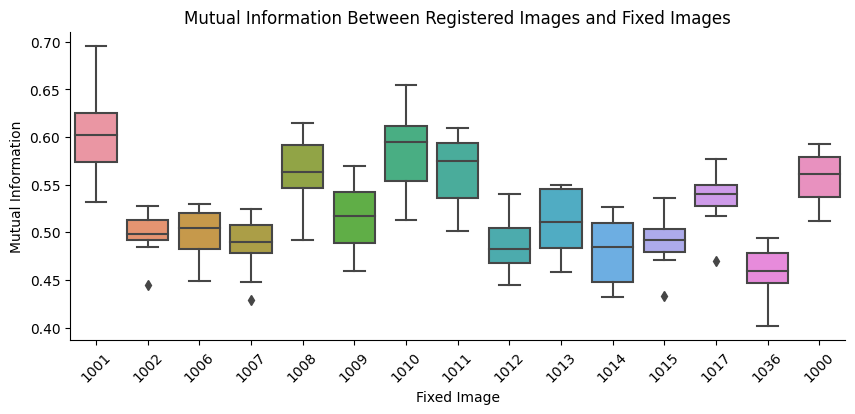

In [10]:
mutual_information_df['fixed_image'] = mutual_information_df.index.values
plot_df = pd.melt(
    mutual_information_df,
    id_vars=['fixed_image'],
    value_vars=[i for i in mutual_information_df.columns if i!='fixed_image'], ignore_index=False
)
plot_df.columns = ['Fixed Image', 'Moving Image', 'Mutual Information']
plot_df = plot_df.loc[plot_df['Mutual Information'] < 1, :]

# Plot
plt.figure(figsize=(10, 4))
plt.title('Mutual Information Between Registered Images and Fixed Images')
sns.boxplot(plot_df, x='Fixed Image', y='Mutual Information')
plt.xticks(rotation=45)
sns.despine()
plt.show()